In [1]:
# # Enable GPU and install dependencies (only on Colab)
# !nvidia-smi
# !pip install torch torchvision


In [33]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets, models
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
from PIL import Image

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [17]:
!ls /kaggle/input/testdataset/TestDataSet

labels_list.json  n02782093  n02808304	n02865351  n02930766  n02988304
n02672831	  n02783161  n02808440	n02869837  n02939185  n02992211
n02676566	  n02786058  n02814533	n02870880  n02948072  n02992529
n02687172	  n02787622  n02814860	n02871525  n02950826  n02999410
n02690373	  n02788148  n02815834	n02877765  n02951358  n03000134
n02692877	  n02790996  n02817516	n02879718  n02951585  n03000247
n02699494	  n02791124  n02823428	n02883205  n02963159  n03000684
n02701002	  n02791270  n02823750	n02892201  n02965783  n03014705
n02704792	  n02793495  n02825657	n02892767  n02966193  n03016953
n02708093	  n02794156  n02834397	n02894605  n02966687  n03017168
n02727426	  n02795169  n02835271	n02895154  n02971356  n03018349
n02730930	  n02797295  n02837789	n02906734  n02974003  n03026506
n02747177	  n02799071  n02840245	n02909870  n02977058  n03028079
n02749479	  n02802426  n02841315	n02910353  n02978881  n03032252
n02769748	  n02804414  n02843684	n02916936  n02979186  n03041632
n02776631	  n028046

In [18]:
# Upload the dataset first (TestDataSet.zip) using the upload widget in Colab
# from google.colab import files
# uploaded = files.upload()

# # Unzip into a directory
!unzip -q /kaggle/input/testdataset/TestDataSet.zip -d data/
!rm -rf data/__MACOSX data/TestDataSet/__MACOSX

# print("Contents:", os.listdir("data/TestDataSet"))
# import os
# os.environ['KAGGLE_USERNAME'] = "athulr"
# os.environ['KAGGLE_KEY'] = ""
# !kaggle datasets download -d athulr/testdataset

unzip:  cannot find or open /kaggle/input/testdataset/TestDataSet.zip, /kaggle/input/testdataset/TestDataSet.zip.zip or /kaggle/input/testdataset/TestDataSet.zip.ZIP.


In [19]:
# Normalization parameters for ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [26]:
# Load label mapping from JSON (provided content)
data_path  = '/kaggle/input/testdataset/TestDataSet'

with open(data_path + "/labels_list.json", "r") as f:
    label_list = json.load(f)

# Build label_map: {synset_id: integer_class_index}
label_map = {}

# Manual mapping of synset_id to index (you must provide the actual mapping)
# For example:
SYNSET_IDS = [
    "n02672831", "n02676566", "n02687172", "n02690373", "n02692877",
    "n02699494", "n02701002", "n02704792", "n02708093", "n02727426",
    "n02730930", "n02747177", "n02749479", "n02769748", "n02776631",
    "n02777292", "n02782093", "n02783161", "n02786058", "n02787622",
    "n02788148", "n02790996", "n02791124", "n02791270", "n02793495",
    "n02794156", "n02795169", "n02797295", "n02799071", "n02802426",
    "n02804414", "n02804610", "n02807133", "n02808304", "n02808440",
    "n02814533", "n02814860", "n02815834", "n02817516", "n02823428",
    "n02823750", "n02825657", "n02834397", "n02835271", "n02837789",
    "n02840245", "n02841315", "n02843684", "n02859443", "n02860847",
    "n02865351", "n02869837", "n02870880", "n02871525", "n02877765",
    "n02879718", "n02883205", "n02892201", "n02892767", "n02894605",
    "n02895154", "n02906734", "n02909870", "n02910353", "n02916936",
    "n02917067", "n02927161", "n02930766", "n02939185", "n02948072",
    "n02950826", "n02951358", "n02951585", "n02963159", "n02965783",
    "n02966193", "n02966687", "n02971356", "n02974003", "n02977058",
    "n02978881", "n02979186", "n02980441", "n02981792", "n02988304",
    "n02992211", "n02992529", "n02999410", "n03000134", "n03000247",
    "n03000684", "n03014705", "n03016953", "n03017168", "n03018349",
    "n03026506", "n03028079", "n03032252", "n03041632", "n03042490"
]

# Map synset_id to index from the labels_list.json
for i, synset_id in enumerate(SYNSET_IDS):
    label_index = 401 + i  # 401 to 500 inclusive
    label_map[synset_id] = label_index


In [27]:
dataset = datasets.ImageFolder(
    root=data_path,
    transform=transform
)

dataset.class_to_idx = label_map

# Fix the sample labels to match ImageNet class indices
valid_samples = []
for s in dataset.samples:
    folder_name = os.path.basename(os.path.dirname(s[0]))
    if folder_name in label_map:
        valid_samples.append((s[0], label_map[folder_name]))
    else:
        print(f"Skipping folder '{folder_name}' (not in label_map)")

dataset.samples = valid_samples
print("Valid images:", len(dataset.samples))


Valid images: 500


# Task 1: Evaluate Pretrained ResNet-34 on Clean Test Set in ImageNet1k_V1

In [28]:
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
model.eval()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 189MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
def evaluate_model(model, dataset, device):
    # Create a DataLoader to iterate over the dataset in batches of 32, without shuffling
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    # Initialize counters for Top-1 and Top-5 correct predictions, and total samples
    top1_correct = 0
    top5_correct = 0
    total = 0

    # Disable gradient calculation for evaluation (saves memory and computations)
    with torch.no_grad():
        # Iterate over the DataLoader to get batches of images and labels
        for images, labels in loader:
            # Move images and labels to the specified device (CPU or GPU)
            images, labels = images.to(device), labels.to(device)
            
            # Get the model's output predictions for the batch
            outputs = model(images)
            
            # Get the indices of the top 5 predicted classes for each sample in the batch
            _, top5 = outputs.topk(5, dim=1)
            
            # The first column of top5 contains the top-1 prediction for each sample
            top1 = top5[:, 0]
            
            # Count how many times the top-1 prediction matches the true label
            top1_correct += (top1 == labels).sum().item()
            
            # For each sample in the batch, check if the true label is among the top-5 predictions
            for i in range(labels.size(0)):
                if labels[i] in top5[i]:
                    top5_correct += 1
            
            # Update the total number of samples processed
            total += labels.size(0)

    # Print the Top-1 accuracy as a percentage
    print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
    # Print the Top-5 accuracy as a percentage
    print(f"Top-5 Accuracy: {100 * top5_correct / total:.2f}%")

# Call the function to evaluate the model on the dataset using the specified device
evaluate_model(model, dataset, device)


Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%


# Task - 1 Result  
- Top-1 Accuracy: 70.40%
- Top-5 Accuracy: 93.20%

Time taken < 1 min. GPU - P100 Kaggle Accelerator

# Task 2 | FGSM ATTACK

In [30]:
def fgsm_attack(model, images, labels, epsilon):
    # Enable gradient calculation for input images (required for FGSM)
    images.requires_grad = True
    
    # Forward pass: get model predictions for the input images
    outputs = model(images)
    
    # Calculate cross-entropy loss between predictions and true labels
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    
    # Clear existing gradients from the model parameters
    model.zero_grad()
    
    # Backward pass: compute gradients of loss with respect to input images
    loss.backward()
    
    # FGSM attack: Create adversarial examples by adding epsilon * sign of gradient to original images
    # .sign() gives -1, 0, or 1 for negative, zero, or positive gradients respectively
    perturbed = images + epsilon * images.grad.data.sign()
    
    # Ensure pixel values stay within original image's valid range (e.g., [0,1] for normalized images)
    # This prevents creating physically impossible/imvisible perturbations
    perturbed = torch.clamp(perturbed, images.min(), images.max())
    
    # Return adversarial examples, detaching from computation graph
    return perturbed.detach()


In [34]:

# Set the perturbation strength for the FGSM attack (epsilon in paper)
epsilon = 0.02

# Initialize lists to store generated adversarial examples and their labels
adv_images = []
adv_labels = []

# Create a DataLoader that processes the dataset one sample at a time (batch_size=1)
# shuffle=False maintains original order of the dataset
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Set model to evaluation mode (disables dropout/batch norm training-specific behaviors)
model.eval()

# Process each sample individually
for image, label in loader:
    # Move clean image and label to the target device (CPU/GPU)
    image, label = image.to(device), label.to(device)
    
    # Generate adversarial example using FGSM attack
    adv = fgsm_attack(model, image, label, epsilon)
    
    # Move adversarial image and label back to CPU memory and store in lists
    adv_images.append(adv.cpu())  # .cpu() moves tensor from GPU to CPU if needed
    adv_labels.append(label.cpu())

# Convert lists of tensors into single tensors by concatenating
# adv_images shape: [num_samples, channels, height, width]
# adv_labels shape: [num_samples]
adv_images = torch.cat(adv_images)
adv_labels = torch.cat(adv_labels)

# Create a PyTorch Dataset object combining adversarial images and labels
# This allows easy use with DataLoader for future operations
adv_dataset = TensorDataset(adv_images, adv_labels)


In [35]:
# Load pre-trained ResNet34 weights trained on ImageNet
weights = models.ResNet34_Weights.IMAGENET1K_V1

# Get the class names (categories) from the weights' metadata
torchvision_classes = weights.meta["categories"]

def unnormalize(img):
    # Reverse the normalization applied during preprocessing
    # Mean and std values used for ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)  # Shape [3,1,1] for broadcasting
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)   # Same shape for element-wise operations
    
    # Denormalize: (img * std) + mean, then clamp to valid [0,1] range
    return (img * std + mean).clamp(0, 1)

def show_attack(original, adversarial, label, pred_label, adv_pred_label):
    # Create a figure with 2 subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Display original image (left subplot)
    # 1. Unnormalize the image tensor
    # 2. Remove batch dimension with squeeze() (if present)
    # 3. Permute dimensions from (C,H,W) to (H,W,C) for matplotlib
    # 4. Convert to numpy array for plotting
    axs[0].imshow(unnormalize(original.squeeze()).permute(1, 2, 0).numpy())
    axs[0].set_title(f"Original\nTrue: {label}\nPred: {pred_label}")
    axs[0].axis("off")  # Remove axes ticks/labels
    
    # Display adversarial image (right subplot)
    axs[1].imshow(unnormalize(adversarial.squeeze()).permute(1, 2, 0).numpy())
    axs[1].set_title(f"Adversarial\nTrue: {label}\nAdv Pred: {adv_pred_label}")
    axs[1].axis("off")
    
    # Adjust spacing and display the plot
    plt.tight_layout()
    plt.show()


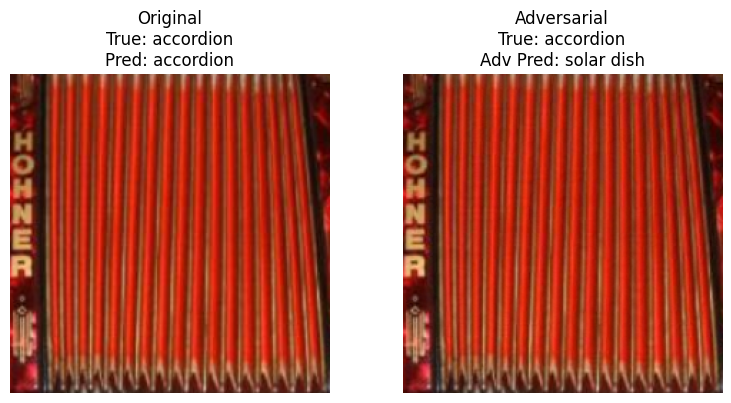

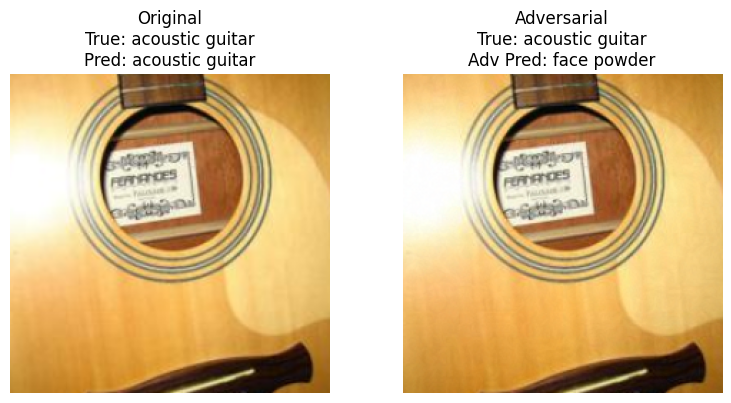

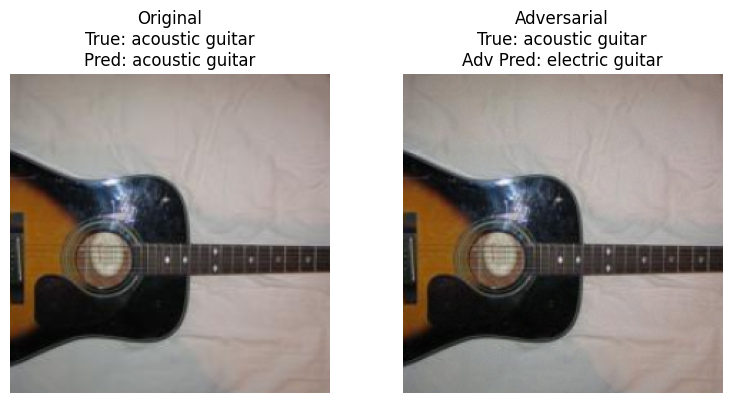

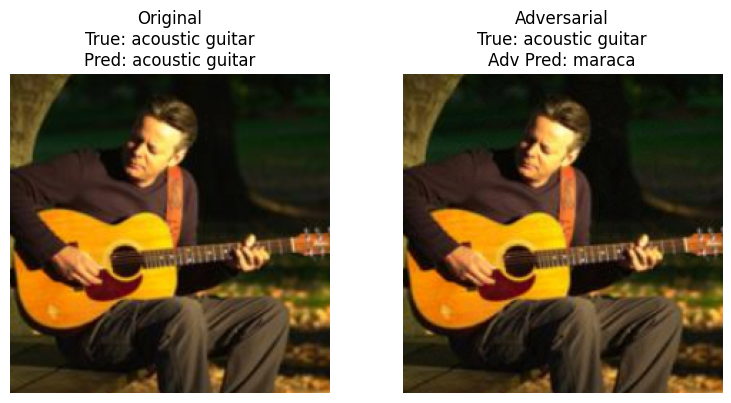

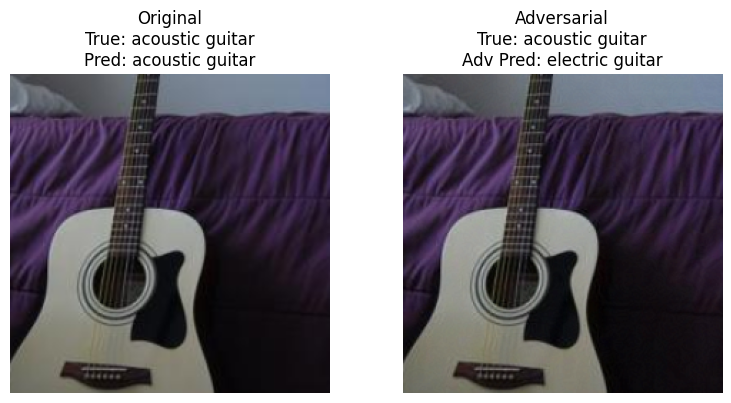

In [36]:
# Counter to track how many successful adversarial examples we've displayed
shown = 0

# Iterate through the entire adversarial dataset
for i in range(len(adv_dataset)):
    # Get original clean image and its true label from the original dataset
    orig_img, label = dataset[i]
    
    # Get adversarial image and its label (same as original) from adversarial dataset
    adv_img, adv_label = adv_dataset[i]
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Add batch dimension with unsqueeze(0) and move to device (CPU/GPU)
        # Get model predictions for original image
        orig_out = model(orig_img.unsqueeze(0).to(device))
        
        # Get model predictions for adversarial image
        adv_out = model(adv_img.unsqueeze(0).to(device))
    
    # Get predicted class index for original image
    orig_pred = orig_out.argmax(1).item()  # argmax along class dimension
    
    # Get predicted class index for adversarial image
    adv_pred = adv_out.argmax(1).item()
    
    # Check if:
    # 1. Model correctly classified original image
    # 2. Model misclassified adversarial image
    if orig_pred == label and adv_pred != label:
        # Display comparison using the show_attack function
        show_attack(
            orig_img, 
            adv_img,
            torchvision_classes[label],          # Convert label index to class name
            torchvision_classes[orig_pred],      # Original prediction
            torchvision_classes[adv_pred]        # Adversarial prediction
        )
        
        # Increment counter
        shown += 1
        
        # Stop after showing 5 successful adversarial examples
        if shown == 5:
            break


In [37]:
evaluate_model(model, adv_dataset, device)


Top-1 Accuracy: 5.00%
Top-5 Accuracy: 29.80%


# Task 2 Results: ResNet34 on ImageNetV1 with FGSM Attack

- Top-1 Accuracy: 5.00%
- Top-5 Accuracy: 29.80%


# Task 3 | Modified Attack | PGD

In [38]:
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, steps=10):
    # Store original images for projection later
    ori_images = images.clone().detach()
    
    # Initialize perturbation with random noise (prevents local minima)
    images = ori_images + 0.001 * torch.randn_like(images)
    images.requires_grad = True  # Enable gradient tracking for input images

    # PGD attack loop - multiple gradient steps
    for _ in range(steps):
        # Forward pass: get model predictions for current perturbed images
        outputs = model(images)
        
        # Calculate loss between predictions and true labels
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        
        # Clear previous gradients from model parameters
        model.zero_grad()
        
        # Backward pass: compute gradients of loss w.r.t. input images
        loss.backward()

        # Gradient ascent step: move images in direction that increases loss
        # sign() gives ±1 direction, alpha controls step size
        images = images + alpha * images.grad.sign()
        
        # Project perturbation back to epsilon-ball around original images
        # 1. Calculate total perturbation (eta) from original
        # 2. Clamp eta to [-epsilon, epsilon]
        # 3. Apply clamped eta to original image
        eta = torch.clamp(images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, images.min(), images.max())
        
        # Detach from computation graph but keep requires_grad=True for next iteration
        images = images.detach_()
        images.requires_grad = True

    # Return final adversarial examples, detaching from computation graph
    return images.detach()


In [39]:
# Initialize lists to store PGD-generated adversarial examples and their labels
pgd_images = []
pgd_labels = []

# Create a DataLoader to process the dataset one sample at a time (batch_size=1)
# shuffle=False maintains original order of samples
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Process each sample individually
for image, label in loader:
    # Move clean image and label to the target device (CPU/GPU)
    image, label = image.to(device), label.to(device)
    
    # Generate adversarial example using PGD attack with parameters:
    # - epsilon: maximum perturbation magnitude (0.02)
    # - alpha: attack step size (0.005)
    # - steps: number of attack iterations (10)
    adv = pgd_attack(model, image, label, epsilon=0.02, alpha=0.005, steps=10)
    
    # Move adversarial image and label back to CPU memory and store in lists
    pgd_images.append(adv.cpu())  # .cpu() ensures compatibility with CPU-based datasets
    pgd_labels.append(label.cpu())

# Convert lists of tensors into single tensors by concatenating
# pgd_images shape: [num_samples, channels, height, width]
# pgd_labels shape: [num_samples]
pgd_images = torch.cat(pgd_images)
pgd_labels = torch.cat(pgd_labels)

# Create a PyTorch Dataset object combining PGD adversarial images and labels
# This allows easy use with DataLoader for future operations
adv_dataset2 = TensorDataset(pgd_images, pgd_labels)


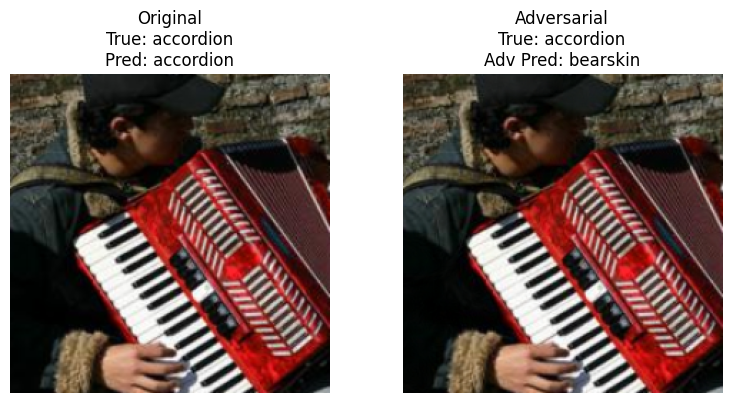

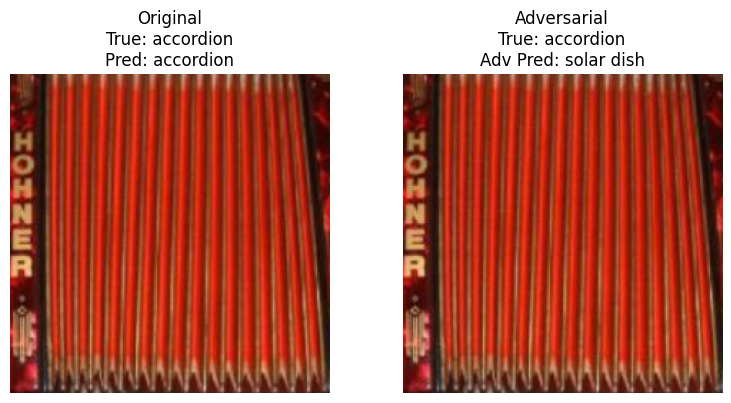

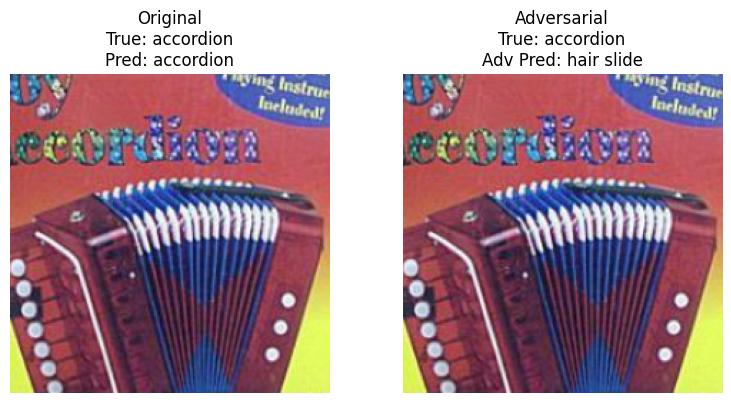

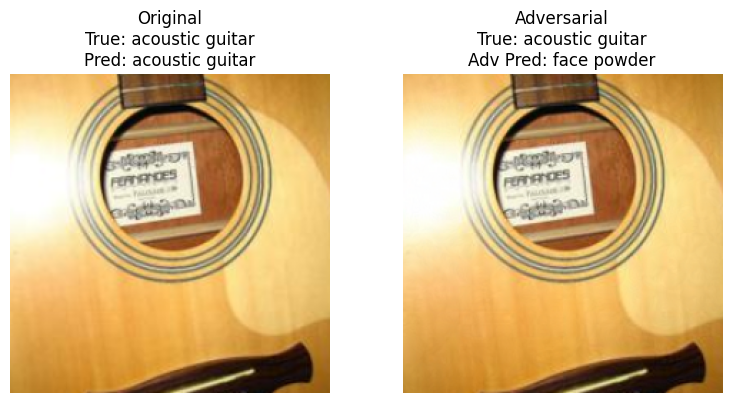

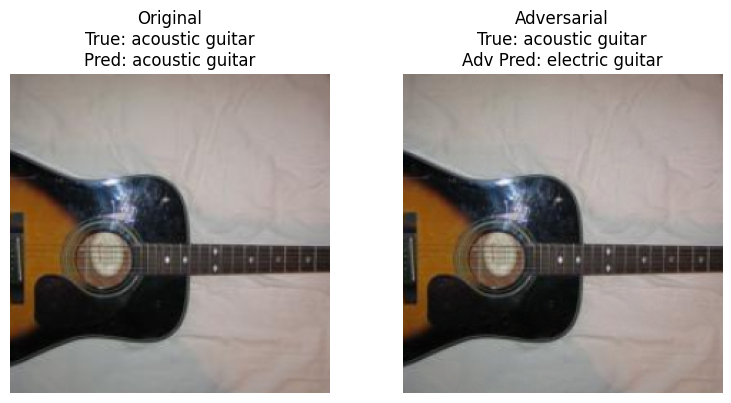

In [40]:
# Reuse visualization functions from previous task (unchanged)
# show_attack() and unnormalize() are defined elsewhere

# Counter to track displayed examples
shown = 0

# Iterate through the second adversarial dataset (adv_dataset2)
for i in range(len(adv_dataset2)):
    # Get original image/label pair from clean dataset
    orig_img, label = dataset[i]
    
    # Get adversarial image/label pair from second adversarial dataset
    adv_img, adv_label = adv_dataset2[i]  # Different from previous dataset
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Add batch dimension and move to device for model input
        # Evaluate original image
        orig_out = model(orig_img.unsqueeze(0).to(device))
        
        # Evaluate adversarial image
        adv_out = model(adv_img.unsqueeze(0).to(device))
    
    # Get predicted class indices
    orig_pred = orig_out.argmax(1).item()  # Original prediction
    adv_pred = adv_out.argmax(1).item()    # Adversarial prediction

    # Only show cases where:
    # - Model was originally correct
    # - Adversarial example fools the model
    if orig_pred == label and adv_pred != label:
        # Display comparison visualization
        show_attack(
            orig_img, 
            adv_img,
            torchvision_classes[label],      # True label name
            torchvision_classes[orig_pred],  # Original prediction name
            torchvision_classes[adv_pred]    # Adversarial prediction name
        )
        
        # Increment counter
        shown += 1
        
        # Stop after displaying 5 successful cases
        if shown == 5:
            break


In [41]:
evaluate_model(model, adv_dataset2, device)


Top-1 Accuracy: 0.00%
Top-5 Accuracy: 7.20%


In [42]:
torch.save({'images': pgd_images, 'labels': pgd_labels}, 'adv_test_set_2.pt')


In [52]:
# --------------------------
# 1) Raw Image Transformations (No Normalization)
# --------------------------
raw_transform = transforms.Compose([
    transforms.Resize(256),          # Resize shorter side to 256
    transforms.CenterCrop(224),      # Crop center 224x224 pixels
    transforms.ToTensor(),           # Convert to [0,1] range tensor
])

# --------------------------
# 2) On-the-Fly Normalization
# --------------------------
def normalize_batch(x):
    # Create mean/std tensors matching input device and shape
    m = torch.tensor(mean, device=x.device, dtype=x.dtype).view(1,3,1,1)  # [1,3,1,1] for batch broadcasting
    s = torch.tensor(std,  device=x.device, dtype=x.dtype).view(1,3,1,1)
    return (x - m) / s  # Standardize batch

# --------------------------
# 3) DeepFool Attack Implementation
# --------------------------
def deepfool(image, model, num_classes=100, overshoot=0.4, max_iter=200):
    # Clone input and enable gradient tracking
    image = image.clone().detach().requires_grad_(True)
    perturbation = torch.zeros_like(image)
    _, orig_label = model(image).max(1)  # Get original prediction

    for _ in range(max_iter):
        logits = model(image + perturbation)  # Current prediction
        fs = logits.detach().cpu().numpy().flatten()
        I = np.argsort(fs)[::-1][:num_classes]  # Top-k class indices

        # Compute gradient for original class
        model.zero_grad()
        logits[0, I[0]].backward(retain_graph=True)
        grad_orig = image.grad.data.clone()

        # Find minimum perturbation across alternative classes
        min_pert = float('inf')
        w = torch.zeros_like(image)
        for k in I[1:]:
            image.grad.data.zero_()
            logits[0, k].backward(retain_graph=True)
            grad_curr = image.grad.data.clone()

            # Calculate perturbation direction and magnitude
            w_k = grad_curr - grad_orig
            f_k = (logits[0, k] - logits[0, I[0]]).item()  # Score difference
            w_norm = w_k.view(-1).norm().item()  # L2 norm of direction
            pert_k = abs(f_k) / (w_norm + 1e-8)  # Required perturbation

            # Track smallest effective perturbation
            if pert_k < min_pert:
                min_pert, w = pert_k, w_k

        # Update cumulative perturbation
        r_i = ((min_pert + 1e-4) * w / (w.view(-1).norm() + 1e-8))
        perturbation += (1 + overshoot) * r_i  # Add overshoot margin

        # Check if attack succeeded
        new_label = model(image + perturbation).max(1)[1]
        if new_label.item() != orig_label.item():
            break

    return perturbation.detach().squeeze(0)  # Remove batch dim

# --------------------------
# 4) Universal Adversarial Perturbation (UAP) Generator
# --------------------------
def universal_perturbation_normalized(loader, model, epsilon=0.02, max_iters=10, delta=0.2, num_classes=100, v = None):
    model.eval()
    # Initialize perturbation tensor
    _, C, H, W = next(iter(loader))[0].shape
    if v is None:
        v = torch.zeros(1, C, H, W, device=device)
    
    # Convert epsilon to normalized space
    std_tensor = torch.tensor(std, device=device).view(1,3,1,1)
    eps_norm = epsilon / std_tensor  # Account for normalization scaling

    num_images = len(loader.dataset)
    fool_rate = 0.0
    iteration = 0

    # Main optimization loop
    while fool_rate < 1 - delta and iteration < max_iters:
        # Batch processing with progress bar
        for imgs_raw, _ in tqdm(loader):
            imgs_raw = imgs_raw.to(device)
            imgs_norm = normalize_batch(imgs_raw)
            
            # Find images not yet fooled by current UAP
            orig = model(imgs_norm).max(1)[1]
            pert = model(imgs_norm + v).max(1)[1]
            mask = (orig == pert)

            if not mask.any().item():  # Skip if all images already fooled
                continue

            # Update perturbation for non-fooled images
            for x_norm in imgs_norm[mask]:
                r_i = deepfool(x_norm + v, model, num_classes).to(device)
                v = v + r_i.unsqueeze(0)  # Accumulate perturbation
                v = torch.clamp(v, -eps_norm, eps_norm)  # Maintain ε-bound

        # Recompute fooling rate
        fooled = 0
        for imgs_raw, _ in loader:
            imgs_raw = imgs_raw.to(device)
            imgs_norm = normalize_batch(imgs_raw)
            fooled += (model(imgs_norm + v).max(1)[1] != model(imgs_norm).max(1)[1]).sum().item()
        
        fool_rate = fooled / num_images
        print(f"Iter {iteration+1}/{max_iters} – Fool Rate: {fool_rate:.3f}")
        iteration += 1

    return v

# --------------------------
# 5) Dataset Preparation
# --------------------------
# Create dataset with raw transforms (no normalization)
dataset_raw = datasets.ImageFolder(data_path, transform=raw_transform)
# Create DataLoader with optimized settings
loader_raw = DataLoader(dataset_raw, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# --------------------------
# 6) Generate & Save UAP
# --------------------------
# Compute universal adversarial perturbation
v = universal_perturbation_normalized(loader_raw, model, epsilon=0.02, max_iters=10, v=v, delta=0.02)
# Save perturbation tensor
torch.save(v, "uap_eps_0.02_norm.pt")


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


Iter 1/10 – Fool Rate: 0.972


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


Iter 2/10 – Fool Rate: 0.992


In [53]:
len(label_map)

100

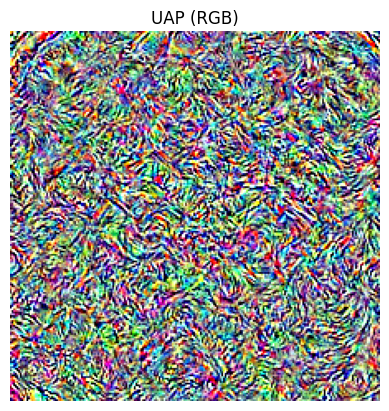

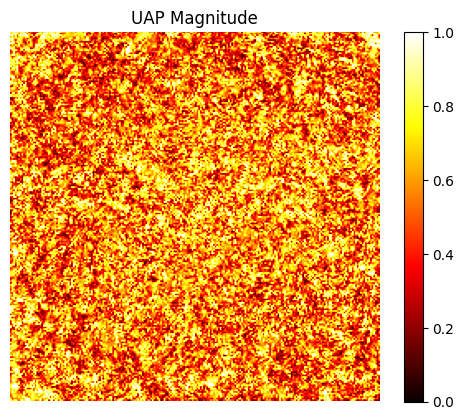

In [59]:
# Load Universal Adversarial Perturbation (UAP) from PyTorch file
# Shape: [Channels, Height, Width] in PyTorch format
# v = torch.load("uap_eps_0.02_norm.pt", map_location="cpu").numpy()

# ImageNet normalization statistics (preprocessing reversal parameters)
mean = np.array([0.485, 0.456, 0.406])[:, None, None]  # [3, 1, 1] for channel-wise broadcasting
std = np.array([0.229, 0.224, 0.225])[:, None, None]   # Standard deviations per channel

# Convert normalized perturbation back to raw pixel space
v_raw = v.cpu().numpy()[0] * std  # Reverse ImageNet preprocessing scaling (no mean addition needed for perturbations)

# print(v_raw.shape)
# Visualization preparation --------------------------------------------------
# 1. Create RGB visualization of the perturbation
v_vis = v_raw - v_raw.min()         # Shift values to start at zero
v_vis = v_vis / v_vis.max()         # Normalize to [0, 1] range
v_vis = np.transpose(v_vis, (1, 2, 0))  # Convert from [C, H, W] to [H, W, C] for matplotlib

plt.figure()
plt.imshow(v_vis)
plt.axis('off')
plt.title("UAP (RGB)")

# 2. Create magnitude heatmap visualization
mag = np.linalg.norm(v_raw, axis=0)  # L2 norm across color channels [H, W]
mag_vis = (mag - mag.min()) / (mag.max() - mag.min())  # Normalize to [0, 1]

plt.figure()
plt.imshow(mag_vis, cmap='hot')  # Use heatmap colormap for better magnitude visualization
plt.axis('off')
plt.title("UAP Magnitude")
plt.colorbar()  # Add scale reference for magnitude
plt.show()


In [60]:
from torch.utils.data import DataLoader, TensorDataset


uap_images = []
uap_labels = []

# v = torch.load("uap_eps_0.02.pt", map_location=device)  # [C, H, W]

model.eval()
for image, label in loader:
    image, label = image.to(device), label.to(device)
    # print(max(image), min(image))
    # image = normalize_batch(image)
    adv = image + v
    # adv_norm = normalize_batch(adv)
    uap_images.append(adv.cpu())
    uap_labels.append(label.cpu())

# Combine into a new dataset
uap_images = torch.cat(uap_images)
uap_labels = torch.cat(uap_labels)
uap_dataset = TensorDataset(uap_images, uap_labels)

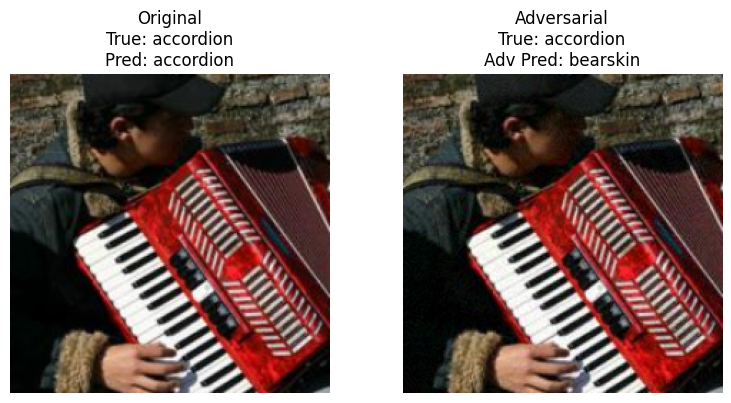

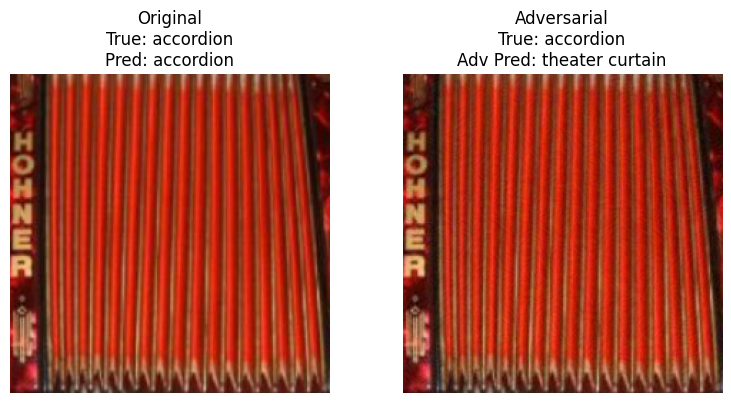

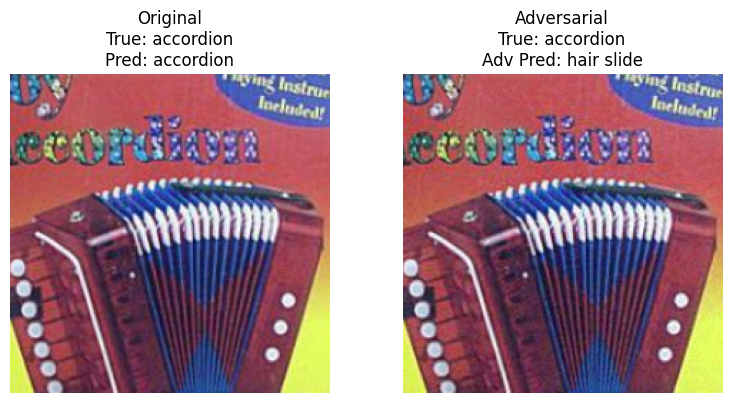

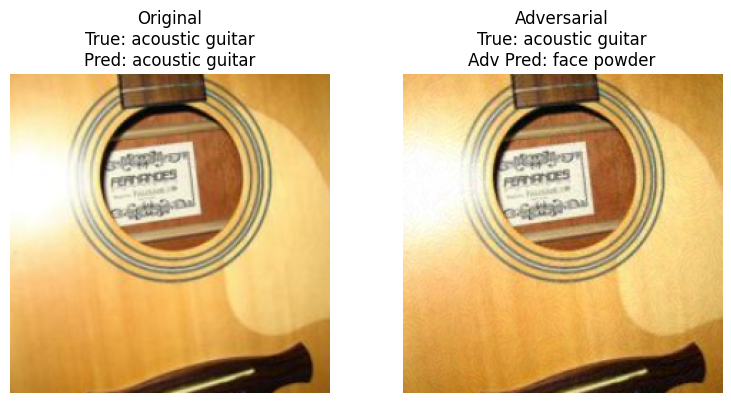

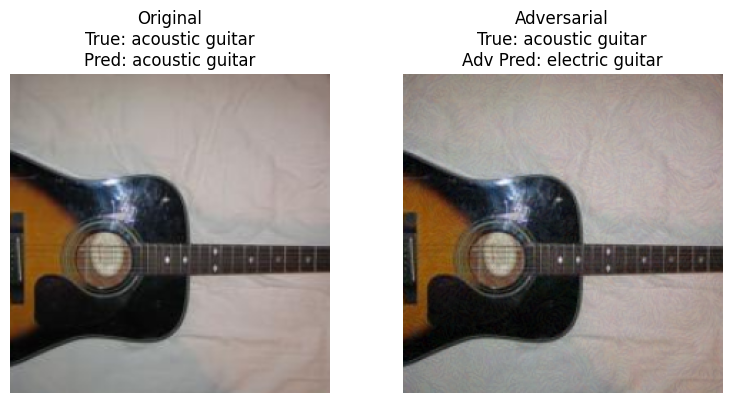

In [61]:
# Reuse show_attack and unnormalize functions

shown = 0
for i in range(len(uap_dataset)):
    orig_img, label = dataset[i]
    adv_img, adv_label = uap_dataset[i]
    with torch.no_grad():
        orig_out = model(orig_img.unsqueeze(0).to(device))
        adv_out = model(adv_img.unsqueeze(0).to(device))
    orig_pred = orig_out.argmax(1).item()
    adv_pred = adv_out.argmax(1).item()

    if orig_pred == label and adv_pred != label:
        show_attack(orig_img, adv_img, torchvision_classes[label], torchvision_classes[orig_pred], torchvision_classes[adv_pred])
        shown += 1
        if shown == 5:
            break

In [62]:
evaluate_model(model, uap_dataset, device)

Top-1 Accuracy: 11.40%
Top-5 Accuracy: 85.00%


# Task 3: 

1. PGD has the best attack - with
   - Top-1 Accuracy: 5.00%
   - Top-5 Accuracy: 29.80%

2. The Universal Adversarial perturbatioin has the following fooling rate.

    - Top-1 Accuracy: 11.40%
    - Top-5 Accuracy: 85.00%

# Task 4 

Patch attacks - Jail Breaking LLMs only only a patch of adversarial perturbations. 

In [64]:
def patch_pgd_attack(model, image, label, patch_size=32, epsilon=0.5, alpha=0.05, steps=10):
    # Clone original image and store on appropriate device (GPU/CPU)
    image = image.clone().detach().to(device)
    ori = image.clone().detach()  # Keep original for reference
    
    # Get image dimensions (assuming CHW format - Channel, Height, Width)
    _, h, w = image.shape
    
    # Randomly select top-left corner coordinates for the adversarial patch
    x = np.random.randint(0, w - patch_size)  # Ensure patch stays within width bounds
    y = np.random.randint(0, h - patch_size)  # Ensure patch stays within height bounds
    
    # Create binary mask to restrict perturbations to the selected patch area
    mask = torch.zeros_like(image)
    mask[:, y:y+patch_size, x:x+patch_size] = 1.0  # 1s in patch region, 0s elsewhere
    
    # Initialize adversarial example with gradient tracking
    adv = image.clone().detach()
    adv.requires_grad = True
    
    # PGD attack loop
    for _ in range(steps):
        # Forward pass through model
        outputs = model(adv.unsqueeze(0))  # Add batch dimension
        
        # Calculate cross-entropy loss between prediction and target label
        loss = torch.nn.functional.cross_entropy(outputs, label.unsqueeze(0))
        
        # Clear previous gradients and compute new gradients
        model.zero_grad()
        loss.backward()
        
        # Update adversarial example using gradient sign (only within patch)
        with torch.no_grad():
            grad = adv.grad.data  # Get gradient of loss w.r.t. adversarial input
            # Apply FGSM update but restricted to patch area via mask
            adv = adv + alpha * torch.sign(grad) * mask
            
            # Calculate total perturbation and clip to epsilon bounds
            perturb = torch.clamp(adv - ori, -epsilon, epsilon)
            
            # Maintain valid pixel range (e.g., 0-255 or 0-1 depending on normalization)
            adv = torch.clamp(ori + perturb, image.min(), image.max()).detach_()
        
        # Re-enable gradient tracking for next iteration
        adv.requires_grad = True
    
    # Return final adversarial example without gradient information
    return adv.detach()


In [65]:
patch_images = []
patch_labels = []

for image, label in DataLoader(dataset, batch_size=1, shuffle=False):
    image, label = image.to(device), label.to(device)
    adv = patch_pgd_attack(model, image.squeeze(0), label.squeeze(0),
                           patch_size=32, epsilon=0.5, alpha=0.05, steps=10)
    patch_images.append(adv.cpu().unsqueeze(0))
    patch_labels.append(label.cpu())

patch_images = torch.cat(patch_images)
patch_labels = torch.cat(patch_labels)
adv_dataset3 = TensorDataset(patch_images, patch_labels)


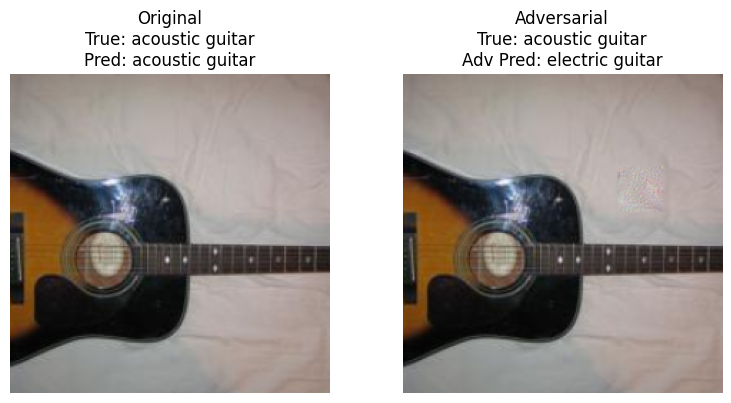

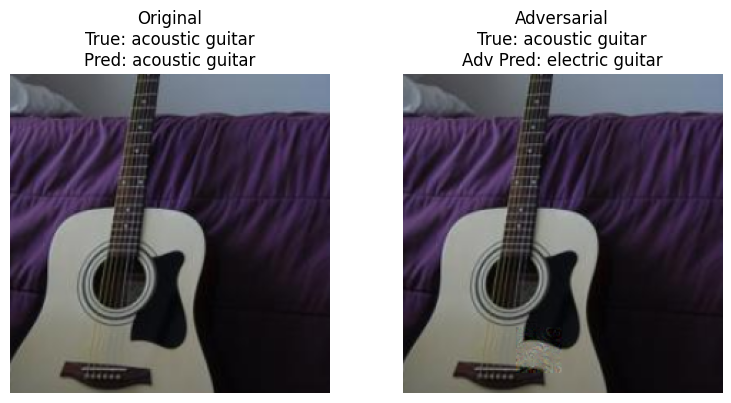

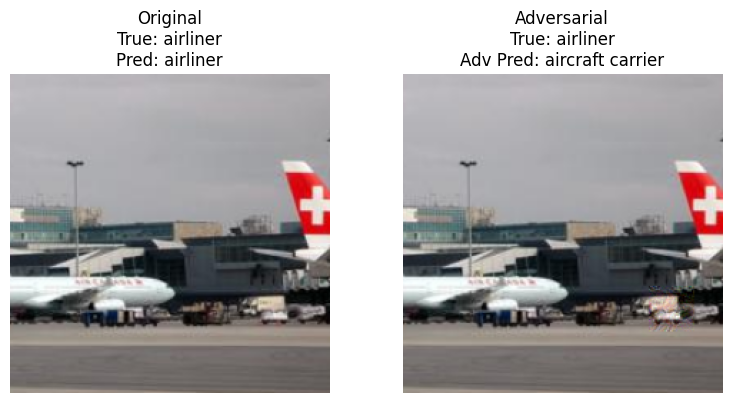

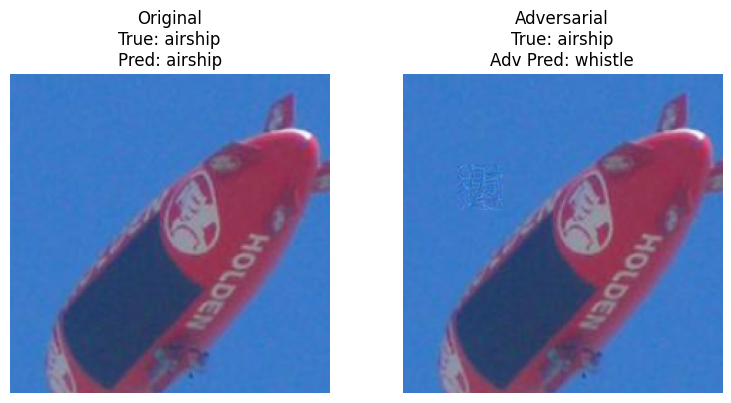

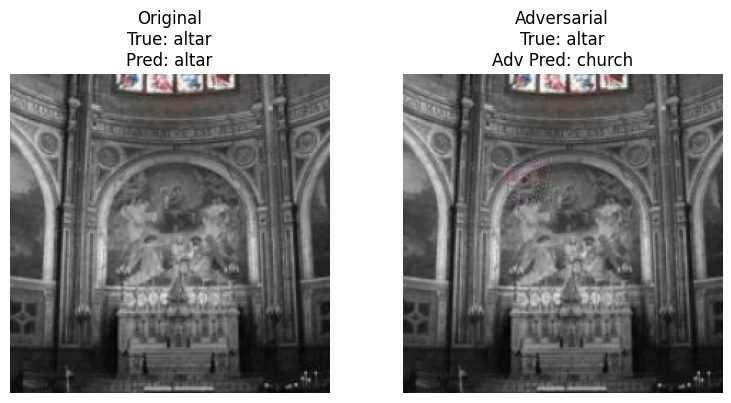

In [66]:
# Reuse show_attack and unnormalize functions

shown = 0
for i in range(len(adv_dataset3)):
    orig_img, label = dataset[i]
    adv_img, adv_label = adv_dataset3[i]
    with torch.no_grad():
        orig_out = model(orig_img.unsqueeze(0).to(device))
        adv_out = model(adv_img.unsqueeze(0).to(device))
    orig_pred = orig_out.argmax(1).item()
    adv_pred = adv_out.argmax(1).item()

    if orig_pred == label and adv_pred != label:
        show_attack(orig_img, adv_img, torchvision_classes[label], torchvision_classes[orig_pred], torchvision_classes[adv_pred])
        shown += 1
        if shown == 5:
            break


In [67]:
evaluate_model(model, adv_dataset3, device)

Top-1 Accuracy: 42.60%
Top-5 Accuracy: 76.60%


In [68]:
torch.save({'images': patch_images, 'labels': patch_labels}, 'adv_test_set_3.pt')


# Task 5

Transf

In [69]:
# Load DenseNet-121
transfer_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device)
transfer_model.eval()

# Get class names (same as before)
transfer_classes = models.DenseNet121_Weights.IMAGENET1K_V1.meta["categories"]


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 197MB/s]


In [70]:
def evaluate_model(model, dataset, device):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top5 = outputs.topk(5, dim=1)
            top1 = top5[:, 0]
            top1_correct += (top1 == labels).sum().item()
            top5_correct += sum(labels[i] in top5[i] for i in range(labels.size(0)))
            total += labels.size(0)

    print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
    print(f"Top-5 Accuracy: {100 * top5_correct / total:.2f}%")


In [71]:
print("🔍 DenseNet-121 on Clean Set")
evaluate_model(transfer_model, dataset, device)

print("\n🔍 DenseNet-121 on FGSM Set")
evaluate_model(transfer_model, adv_dataset, device)

print("\n🔍 DenseNet-121 on PGD Set")
evaluate_model(transfer_model, adv_dataset2, device)

print("\n🔍 DenseNet-121 on Patch Set")
evaluate_model(transfer_model, adv_dataset3, device)

print("\n🧢  ResNet34 on UAP")
evaluate_model(model, uap_dataset, device)

print("\n🔍 DenseNet-121 on UAP")
evaluate_model(transfer_model, uap_dataset, device)

🔍 DenseNet-121 on Clean Set
Top-1 Accuracy: 70.80%
Top-5 Accuracy: 91.20%

🔍 DenseNet-121 on FGSM Set
Top-1 Accuracy: 58.80%
Top-5 Accuracy: 84.80%

🔍 DenseNet-121 on PGD Set
Top-1 Accuracy: 58.80%
Top-5 Accuracy: 87.00%

🔍 DenseNet-121 on Patch Set
Top-1 Accuracy: 68.60%
Top-5 Accuracy: 89.60%

🧢  ResNet34 on UAP
Top-1 Accuracy: 11.40%
Top-5 Accuracy: 85.00%

🔍 DenseNet-121 on UAP
Top-1 Accuracy: 68.20%
Top-5 Accuracy: 89.00%
